In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader

from rml import training
from rml import utils
from rml.utils import plotting

from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS

from unet.unet.unet_parts import *

In [2]:
%matplotlib inline

In [3]:
utils.utils.set_is_notebook(True)
device = utils.utils.device

In [4]:
fs = 48000
bs = 32
stroke_width = 10
patch_width = 128
patch_height = 64

In [5]:
files = mlp.get_all_files("corpus/wav48")
files = list(filter(lambda x: x[-3:] == "wav", files))
files = np.random.permutation(files)

In [6]:
stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width, fs)
stroke_mask_not = ~stroke_mask

purge_mask = stroke_mask.float()
keep_mask = stroke_mask_not.float()

In [7]:
preprocess = WAVAudioDS.polar_preprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width, 
    patch_height
)

ds_train = WAVAudioDS(files[:2500], lambda x: x * purge_mask, preprocess, patch_width) # just using a fraction of our data
ds_test = WAVAudioDS(files[2500:2600], lambda x: x * purge_mask, preprocess, patch_width)

dl_train = DataLoader(ds_train, batch_size=bs, num_workers=4, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=bs, num_workers=4, shuffle=False)

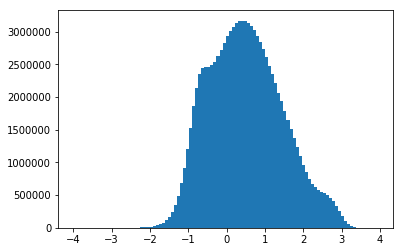

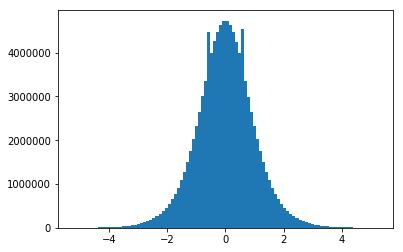

In [8]:
# the data has a really nice distribution now :)
plt.hist(ds_train.stroke[0].view(-1), bins=100)
plt.show()

plt.hist(ds_train.stroke[1].view(-1), bins=100)
plt.show()

In [9]:
mse = torch.nn.MSELoss()
loss_mask =  stroke_mask_not.float().to(device)

def MSEGapLoss(pred, targ):
    return mse(pred * loss_mask, targ * loss_mask)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(2, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, 2)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
model = UNet().to(device)
optim = torch.optim.Adam(model.parameters())

In [11]:
train_data = training.optimize(1, model, optim, MSEGapLoss, dl_train, dl_test) 


Epoch: 0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Train Cost: 0.013197653376446745
Test Cost: 0.013037847641568918



(0.0125, 0.014)

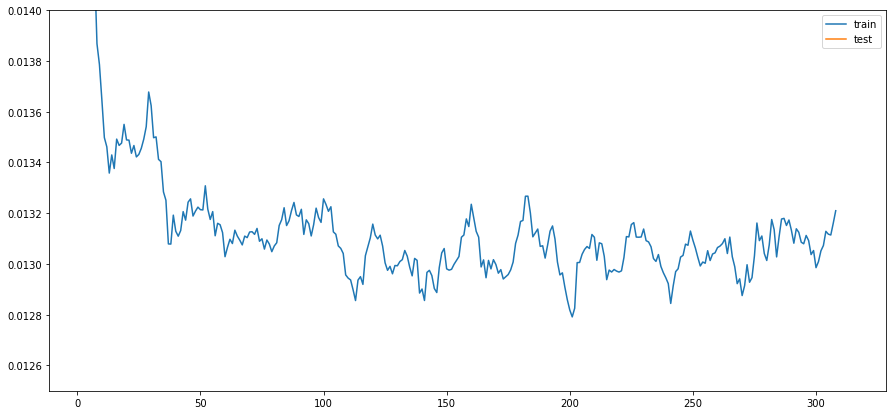

In [20]:
plotting.plot_train_data(train_data)
plt.ylim(ymin=0.0125, ymax=0.014)

In [13]:
X_orig, y_orig = ds_test[16]

pred_orig = model(X_orig.unsqueeze(0).to(device)).squeeze(0)
pred_orig = X_orig.cpu() + loss_mask.cpu() * pred_orig.cpu()

y = WAVAudioDS.torch_to_freqs(y_orig, normalization.denorm_polar)
_, y_time = audio.istft(y, fs)

pred = WAVAudioDS.torch_to_freqs(pred_orig, normalization.denorm_polar)
_, pred_time = audio.istft(pred, fs)

X = WAVAudioDS.torch_to_freqs(X_orig, normalization.denorm_polar)
_, X_time = audio.istft(X, fs)

In [14]:
audio.play_audio(y_time, rate=fs)

In [15]:
audio.play_audio(pred_time, rate=fs)

In [16]:
audio.play_audio(X_time, rate=fs)

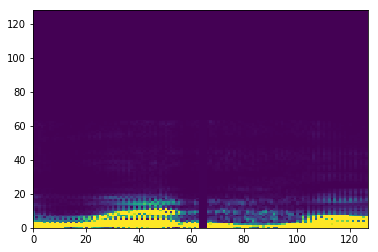

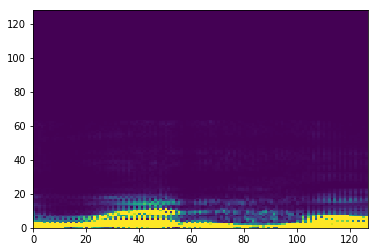

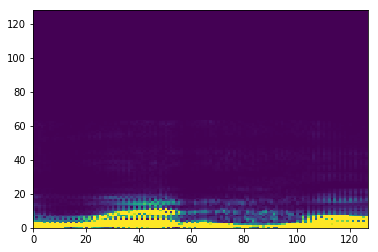

In [17]:
audio.show_spectra(X)
plt.show()

audio.show_spectra(y)
plt.show()

audio.show_spectra(pred)
plt.show()